In [44]:
import numpy as np
import random
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
import pandas as pd
from typing import List, Tuple
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from common import haversine_cluster, str_contains_sub

In [2]:
df = pd.read_csv("data/mappers_processed.csv")
if "id" in df.columns:
    df = df.drop(["id"], axis=1)

In [3]:
df_clusters = pd.read_csv("data/clusters_sfbay.csv")

In [4]:
# Limit data points to those that fall within the clusterable regions
lat_bounds = [df_clusters["cluster_lat"].min(), df_clusters["cluster_lat"].max()]
long_bounds = [df_clusters["cluster_long"].min(), df_clusters["cluster_long"].max()]

for prefix in {"target", "hotspot1", "hotspot2", "hotspot3"}:
    df = df[df[f"{prefix}_lat"] > min(lat_bounds)]
    df = df[df[f"{prefix}_lat"] < max(lat_bounds)]
    df = df[df[f"{prefix}_long"] > min(long_bounds)]
    df = df[df[f"{prefix}_long"] < max(long_bounds)]

In [5]:
df.shape

(463545, 29)

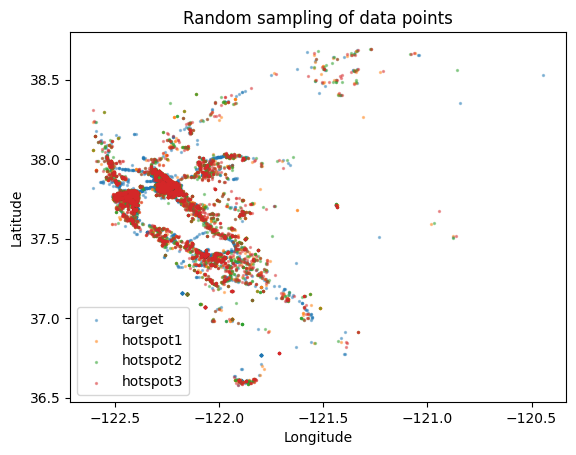

In [6]:
subset = df.sample(n=min(len(df), 5000))
for prefix in ["target"] + [f"hotspot{i}" for i in range(1,4)]:
    plt.scatter(subset[f"{prefix}_long"], subset[f"{prefix}_lat"], s=2, alpha=0.4, label=f"{prefix}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Random sampling of data points")
plt.legend()

In [7]:
if "naive_tri_alt" in df.columns:
    df = df.rename(columns={"naive_tri_alt": "naive_tri_altitude"})

In [10]:
# Add cluster assignments coords
for prefix in ["target", "hotspot1", "hotspot2", "hotspot3", "centroid_projected", "naive_tri"]:
    df[f"{prefix}_cluster_id"] = haversine_cluster(
        points_lat_long_deg=df[[f"{prefix}_lat", f"{prefix}_long"]].to_numpy(),
        centroids_lat_long_deg=df_clusters[["cluster_lat", "cluster_long"]].to_numpy(),
        trace=True,
    )

100%|██████████| 1184/1184 [00:21<00:00, 54.12it/s]


In [50]:
# Add normalized lat, long
for prefix in ["target", "hotspot1", "hotspot2", "hotspot3", "centroid_projected", "naive_tri"]:
    # Normalize lat values
    df[f"{prefix}_lat_norm"] = df[f"{prefix}_lat"] = 1 - 2 * (df[f"{prefix}_lat"] + 90.0) / 180.0
    df[f"{prefix}_long_norm"] = df[f"{prefix}_long"] = 1 - 2 * (df[f"{prefix}_long"] + 180.0) / 360.0

In [51]:
# noramlize cluster_id
for prefix in ["target", "hotspot1", "hotspot2", "hotspot3", "centroid_projected", "naive_tri"]:
    df[f"{prefix}_cluster_id_norm"] = 2 * df[f"{prefix}_cluster_id"] / len(df_clusters) - 1

In [52]:
# Split the data into train and test with 80 train / 20 test
df_train, df_val = train_test_split(df, test_size=0.2, random_state = 1)

In [53]:
label_cols = ["target_cluster_id"]
naive_tri_cols = ["naive_tri_cluster_id"]
sample_cols = [
        'naive_tri_cluster_id_norm', 'centroid_projected_cluster_id_norm', 'hotspot1_cluster_id_norm', 'hotspot2_cluster_id_norm', 'hotspot3_cluster_id_norm', 
        'centroid_projected_lat_norm', 'centroid_projected_long_norm',
        'hotspot1_lat_norm', 'hotspot1_long_norm', 
        'hotspot2_lat_norm', 'hotspot2_long_norm', 
        'hotspot3_lat_norm', 'hotspot3_long_norm', 
        'hotspot1_rssi', 'hotspot2_rssi', 'hotspot3_rssi', 
        'hotspot1_snr', 'hotspot2_snr','hotspot3_snr',
        # 'hotspot1_fspl_dist_km', 'hotspot2_fspl_dist_km', 'hotspot3_fspl_dist_km',
        'naive_tri_lat_norm', 'naive_tri_long_norm',
]

y_train = df_train[label_cols].to_numpy()
y_val = df_val[label_cols].to_numpy()
y_val_naive = df_val[naive_tri_cols].to_numpy()

print(y_train.shape, y_train.min(), y_train.max())
print(y_val.shape, y_val.min(), y_val.max())

(370836, 1) 0 1183
(92709, 1) 0 1183


In [55]:

x_train = df_train[sample_cols].to_numpy()
x_val = df_val[sample_cols].to_numpy()

# Normalize all features to expected range -1:1 based on consideration of the training data alone
X_TRAIN_MIN = x_train.min(axis=0)
X_TRAIN_RANGE = x_train.ptp(axis=0)

for i, s in enumerate(sample_cols):
    # Avoid re-normalizing anything that was already normalized
    if str_contains_sub(s, ["_norm"]):
        continue
    print(f"Normalizing: {s}...")
    x_train[:, i] = 2 * (x_train[:, i] - X_TRAIN_MIN[i]) / X_TRAIN_RANGE[i] - 1
    x_val[:, i] = 2 * (x_val[:, i] - X_TRAIN_MIN[i]) / X_TRAIN_RANGE[i] - 1

print(x_train.shape, x_train.min(), x_train.max())
print(x_val.shape, x_val.min(), x_val.max())

Normalizing: hotspot1_rssi...
Normalizing: hotspot2_rssi...
Normalizing: hotspot3_rssi...
Normalizing: hotspot1_snr...
Normalizing: hotspot2_snr...
Normalizing: hotspot3_snr...
(370836, 21) -1.0 1.0
(92709, 21) -1.0 1.018867924528302


In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [57]:
torch.manual_seed(42)

Xtr, Ytr = torch.tensor(x_train).float().to(device), torch.tensor(y_train).to(device)
Xval, Yval = torch.tensor(x_val).float().to(device), torch.tensor(y_val).to(device)
Yval_NAIVE = torch.tensor(y_val_naive).float().to(device)
def get_batch(batch_size:int =32, is_train: bool=True):
    # generate a small batch of data of inputs x and targets y
    src_data = Xtr if is_train else Xval
    labels = Ytr if is_train else Yval
    ix = torch.randint(0, src_data.shape[0], (batch_size,))
    return src_data[ix], labels[ix].squeeze()

In [58]:
class MlpTriangulationModel(nn.Module):
    def __init__(
        self, 
        input_size: int, 
        output_size: int, 
        hidden_layer_size: int = 64, 
        n_hidden_layers: int = 5, 
        b_norm: bool = True,
    ):
        super().__init__()
        fan_in_out = [
            (input_size, hidden_layer_size)
        ] + (n_hidden_layers - 1) * [(hidden_layer_size, hidden_layer_size)]
        layers = [
            # Flatten the data for each node into a single vector like so: [x1,y1,ss1, x2,y2,ss2...]
            nn.Flatten(start_dim=1)
        ]
        for fan_in, fan_out in fan_in_out:
            layers += (
                [nn.Linear(fan_in, fan_out, bias=not b_norm)]
                + ([nn.BatchNorm1d(fan_out)] if b_norm else [])
                + [nn.ReLU()]
            )

        layers.append(nn.Linear(fan_in_out[-1][-1], output_size))
        # parameter init
        with torch.no_grad():
            layers[-1].weight *= 0.1  # make last layer less confident
        self.layers = nn.Sequential(*layers)

    def forward(self, samples: Tensor, targets: Tensor = None) -> Tuple[Tensor, Tensor]:
        logits = self.layers(samples)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)
        return logits, loss

In [70]:
model = MlpTriangulationModel(
    input_size = x_train.shape[-1], # number of channels/features in each input sample
    output_size = len(df_clusters), # number of predictable clusters
)
model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Create optimizer
init_lr = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

0.095328 M parameters


In [71]:
# Find a good learning rate
if False:
    lri = []
    lossi = []
    lre = torch.linspace(-6, -2, 1000)
    lrs = 10**lre
    BATCH_SIZE = 256
    for i, lr in enumerate(lrs):
        for g in optimizer.param_groups:
            g['lr'] = lr
        # Get a random batch
        Xb, Yb = get_batch(batch_size=BATCH_SIZE, is_train=True)

        # Predict coordinates and evaluate loss
        logits, loss = model(Xb,Yb.squeeze())
        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        lri.append(lr.item())
        lossi.append(loss.item())

    plt.plot(lri, lossi)
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")

In [72]:
naive_val_acc = (Yval.squeeze() == Yval_NAIVE.squeeze()).sum().item()/Yval.size(0)
print(f"NAIVE Trilat Val Cluster Cls Acc: {100*naive_val_acc:.2f}%")

NAIVE Trilat Val Cluster Cls Acc: 29.10%


In [73]:
# Training
BATCH_SIZE = 256
MAX_STEPS = 20000
LR_DECAY = [6000, 12000]
PRINT_INTERVAL = MAX_STEPS // 25
stats = []

def eval_accuracy(data:Tensor, labels:Tensor)->Tuple[float, float]:
    with torch.no_grad():
        predictions, _ = model(data)
    # get highest scores & their cluster idx
    # cluster_predictions = torch.argmax(predictions, dim=1)
    scores, predicted_cluster_idxs = predictions.max(dim=1)
    n = data.size(0)
    assert predicted_cluster_idxs.size(0) == n
    return (predicted_cluster_idxs == labels).sum().item()/n

model.train()
lr = init_lr
for i in range(MAX_STEPS):
    # Get a random batch
    Xb, Yb = get_batch(batch_size=BATCH_SIZE, is_train=True)

    # Predict coordinates and evaluate loss
    logits, loss = model(Xb,Yb)
    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    step_stats = {
        "step": i,
        "loss": loss.item(),
        "lr": lr
    }
    if i % PRINT_INTERVAL == 0:
        with torch.no_grad():
            classification_accuracy = eval_accuracy(data=Xval, labels=Yval.squeeze())
            step_stats["val_cluster_classification_accuracy"] = classification_accuracy
        print(f"Step: {i},\t Loss: {loss.item():.6f},\tVal Cluster Cls Acc: {100*classification_accuracy:.2f}%")
    if i in LR_DECAY:
        print("Adjusting LR")
        for g in optimizer.param_groups:
            lr = lr * 0.1
            g['lr'] *= 0.1
    stats.append(step_stats)


Step: 0,	 Loss: 7.070842,	Val Cluster Cls Acc: 18.61%
Step: 800,	 Loss: 2.057340,	Val Cluster Cls Acc: 51.36%
Step: 1600,	 Loss: 1.624697,	Val Cluster Cls Acc: 56.74%
Step: 2400,	 Loss: 1.569008,	Val Cluster Cls Acc: 57.97%
Step: 3200,	 Loss: 1.915164,	Val Cluster Cls Acc: 58.43%
Step: 4000,	 Loss: 1.557358,	Val Cluster Cls Acc: 60.26%
Step: 4800,	 Loss: 1.724063,	Val Cluster Cls Acc: 59.23%
Step: 5600,	 Loss: 1.570769,	Val Cluster Cls Acc: 60.52%
Adjusting LR
Step: 6400,	 Loss: 1.515213,	Val Cluster Cls Acc: 62.75%
Step: 7200,	 Loss: 1.527689,	Val Cluster Cls Acc: 63.31%
Step: 8000,	 Loss: 1.265048,	Val Cluster Cls Acc: 63.44%
Step: 8800,	 Loss: 1.256175,	Val Cluster Cls Acc: 63.40%
Step: 9600,	 Loss: 1.287928,	Val Cluster Cls Acc: 63.54%
Step: 10400,	 Loss: 1.364461,	Val Cluster Cls Acc: 63.78%
Step: 11200,	 Loss: 1.381634,	Val Cluster Cls Acc: 63.83%
Step: 12000,	 Loss: 1.271157,	Val Cluster Cls Acc: 63.84%
Adjusting LR
Step: 12800,	 Loss: 1.197481,	Val Cluster Cls Acc: 64.10%
Step:

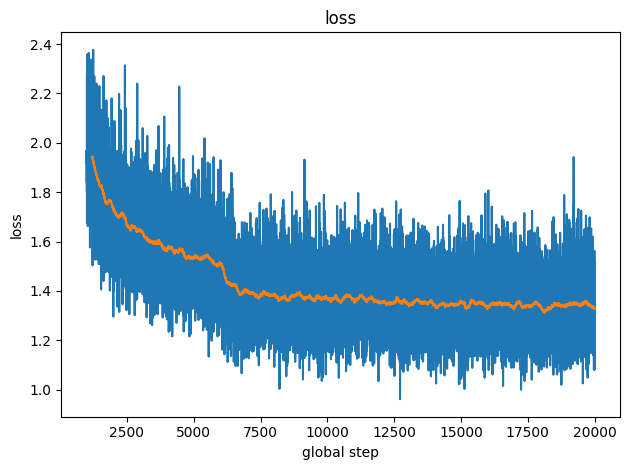

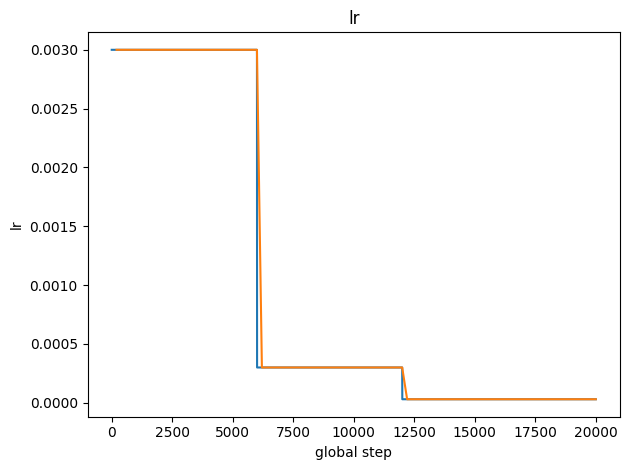

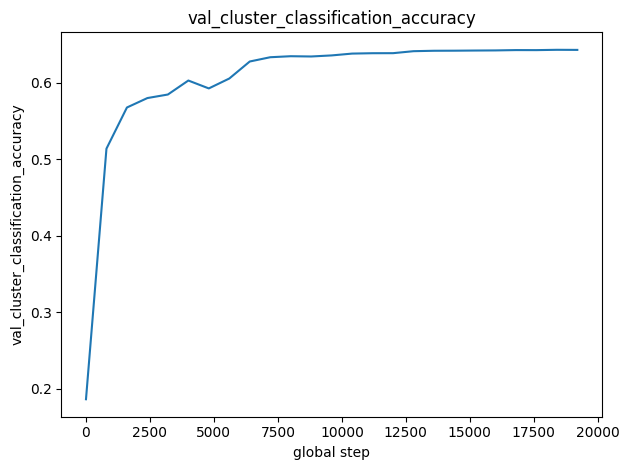

In [74]:
plot_contents = {}
for i, step_stats in enumerate(stats):
    step = step_stats.pop("step", i)
    for k, v in step_stats.items():
        if k not in plot_contents:
            plot_contents[k] = {"x": [], "y":[]}
        plot_contents[k]["x"].append(step)
        plot_contents[k]["y"].append(v)
for k, v in plot_contents.items():
    x, y = np.asarray(v["x"]), np.asarray(v["y"])
    if k == "loss":
        x = x[1000:]
        y = y[1000:]
    plt.figure()
    plt.title(k)
    plt.plot(x,y)
    n = y.shape[0] // 100
    if n > 10:
        smoothed = np.convolve(y, np.ones(n), 'valid') / n
        smoothed = np.average(np.lib.stride_tricks.sliding_window_view(y, n), axis=1)
        plt.plot(x[n-1:], smoothed, label="Smoothed")
    plt.xlabel("global step")
    plt.ylabel(k)
    plt.tight_layout()